### In this notebook we will try a first xgboost model without any features engineering and features selection and without any hyperparameters tuning, just to have a general overview about the score(benchmark) we will get and try to improve it. 
### below we've done a stratified 5 fold cross validation with xgboost model + target encoding (loss = 0.508)  

In [124]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from category_encoders.target_encoder import TargetEncoder 
from category_encoders.m_estimate import MEstimateEncoder
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel 
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder
from scipy.stats import chi2_contingency, chi2
sns.set_theme()

In [2]:
train = pd.read_csv("train.csv.zip")
test = pd.read_csv("test.csv.zip")

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024 ** 2 # just added 
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage(deep=True).sum() / 1024 ** 2
    percent = 100 * (start_mem - end_mem) / start_mem
    print('Mem. usage decreased from {:5.2f} Mb to {:5.2f} Mb ({:.1f}% reduction)'.format(start_mem, end_mem, percent))
    return df

In [4]:
train = reduce_mem_usage(df=train)
test = reduce_mem_usage(df=test)

Mem. usage decreased from 216.76 Mb to 141.86 Mb (34.6% reduction)
Mem. usage decreased from 216.02 Mb to 141.84 Mb (34.3% reduction)


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114321 entries, 0 to 114320
Columns: 133 entries, ID to v131
dtypes: float16(108), int32(1), int8(5), object(19)
memory usage: 41.1+ MB


In [6]:
train.head()

,ID,target,v1,v2,v3,v4,v5,v6,v7,v8,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,3,1,1.335938,8.726562,C,3.921875,7.914062,2.599609,3.177734,0.012939,...,8.000000,1.990234,0.035767,AU,1.803711,3.113281,2.023438,0,0.636230,2.857422
1,4,1,NaN,NaN,C,NaN,9.187500,NaN,NaN,2.300781,...,NaN,NaN,0.599121,AF,NaN,NaN,1.958008,0,NaN,NaN
2,5,1,0.943848,5.308594,C,4.410156,5.324219,3.980469,3.927734,0.019638,...,9.335938,2.478516,0.013451,AE,1.773438,3.921875,1.120117,2,0.883301,1.176758
3,6,1,0.797363,8.304688,C,4.226562,11.625000,2.097656,1.987305,0.171997,...,7.019531,1.812500,0.002268,CJ,1.415039,2.955078,1.991211,1,1.676758,1.034180
4,8,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Z,NaN,NaN,NaN,0,NaN,NaN


In [7]:
dis_col = [col for col in train.columns if train[col].dtype in ["int32", "int8"] and col not in ["ID", "target"]]
cat_col = [col for col in train.columns if train[col].dtype == "O"]
cont_col = [col for col in train.columns if col not in dis_col + cat_col + ["ID", "target"]]

In [8]:
data = train.copy()

In [9]:
data[cat_col] = data[cat_col].fillna(value="NONE")
data[cont_col] = data[cont_col].fillna(value=-1)

In [10]:
data[cat_col].isnull().sum()

v3      0
v22     0
v24     0
v30     0
v31     0
v47     0
v52     0
v56     0
v66     0
v71     0
v74     0
v75     0
v79     0
v91     0
v107    0
v110    0
v112    0
v113    0
v125    0
dtype: int64

In [13]:
"""
for col in cat_col:
    lbe = LabelEncoder()
    data[col] = lbe.fit_transform(data[col])
"""

In [14]:
"""
features = [col for col in data.columns if col not in ["ID","target"]]
X = data[features]
y = data["target"]
sel = SelectFromModel(RandomForestClassifier())
sel.fit_transform(X,y)
sel.get_support()
selected_feat = data[features].columns[(sel.get_support())]
"""

In [15]:
importances = sel.estimator_.feature_importances_

In [16]:
feat_importances = pd.Series(importances, index= features)

<AxesSubplot:>

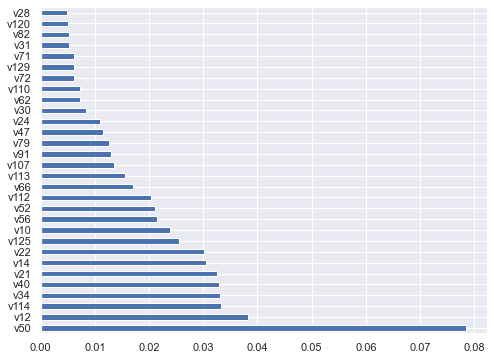

In [17]:
plt.figure(figsize=(8,6))
feat_importances.nlargest(30).plot(kind='barh')

In [18]:
new_features = feat_importances.sort_values(ascending=False).head(25).index.tolist()

In [20]:
len(new_features)

25

In [21]:
dis_col = [col for col in new_features if train[col].dtype in ["int32", "int8"] and col not in ["ID", "target"]]
cat_col = [col for col in new_features if train[col].dtype == "O"]
cont_col = [col for col in new_features if col not in dis_col + cat_col + ["ID", "target"]]

In [22]:
train[cat_col].head()

,v22,v125,v56,v52,v112,v66,v113,v107,v91,v79,v47,v24,v30,v110
0,XDX,AU,DI,G,O,C,NaN,E,A,E,C,C,C,B
1,GUV,AF,DY,G,U,A,G,B,B,D,E,C,C,A
2,FQ,AE,AS,F,S,A,NaN,C,G,E,C,E,NaN,B
3,ACUE,CJ,BW,H,J,A,NaN,B,B,B,C,D,C,B
4,HIT,Z,NaN,H,T,C,G,C,G,C,I,E,NaN,A


In [ ]:
"""
for col in cat_col:
    plt.figure(figsize=(8,6))
    sns.countplot(x=col, data=train)
"""

In [23]:
# as you can see from the distribution plot we have some similarity between (v91, v107) we can drop one of them.
new_features.remove("v107")

<Figure size 576x432 with 0 Axes>

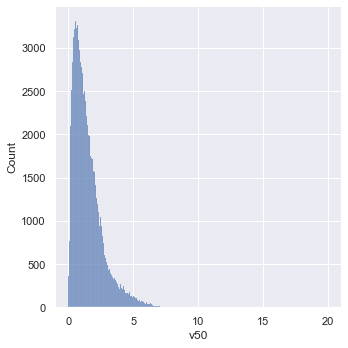

<Figure size 576x432 with 0 Axes>

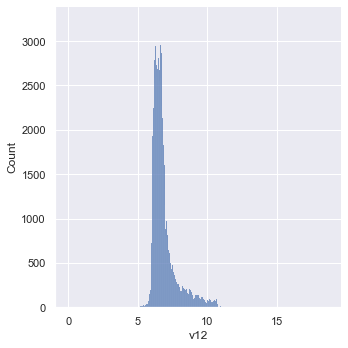

<Figure size 576x432 with 0 Axes>

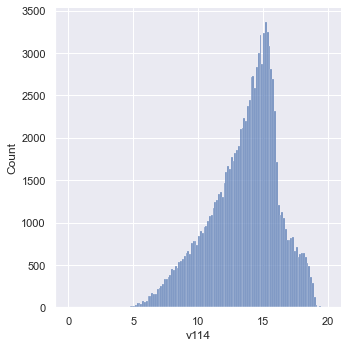

<Figure size 576x432 with 0 Axes>

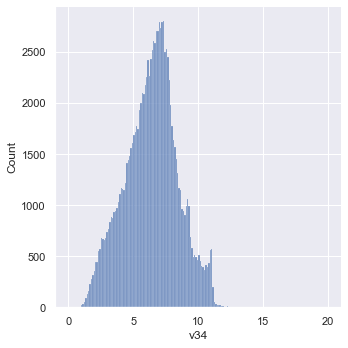

<Figure size 576x432 with 0 Axes>

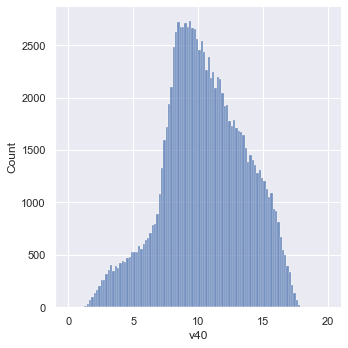

<Figure size 576x432 with 0 Axes>

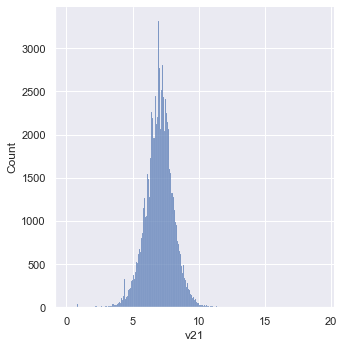

<Figure size 576x432 with 0 Axes>

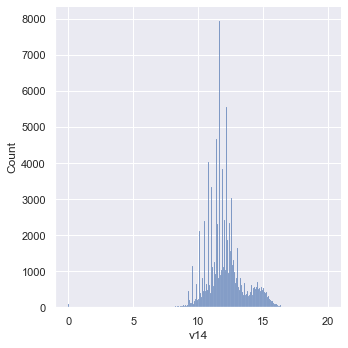

<Figure size 576x432 with 0 Axes>

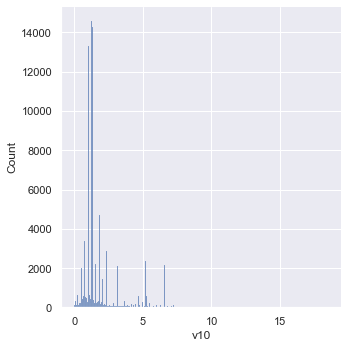

In [24]:
for col in cont_col:
    plt.figure(figsize=(8,6))
    sns.displot(x=col, data=train)

In [52]:
features = [col for col in train.columns if col not in ["ID","target"]]

In [53]:
features

['v1',
 'v2',
 'v3',
 'v4',
 'v5',
 'v6',
 'v7',
 'v8',
 'v9',
 'v10',
 'v11',
 'v12',
 'v13',
 'v14',
 'v15',
 'v16',
 'v17',
 'v18',
 'v19',
 'v20',
 'v21',
 'v22',
 'v23',
 'v24',
 'v25',
 'v26',
 'v27',
 'v28',
 'v29',
 'v30',
 'v31',
 'v32',
 'v33',
 'v34',
 'v35',
 'v36',
 'v37',
 'v38',
 'v39',
 'v40',
 'v41',
 'v42',
 'v43',
 'v44',
 'v45',
 'v46',
 'v47',
 'v48',
 'v49',
 'v50',
 'v51',
 'v52',
 'v53',
 'v54',
 'v55',
 'v56',
 'v57',
 'v58',
 'v59',
 'v60',
 'v61',
 'v62',
 'v63',
 'v64',
 'v65',
 'v66',
 'v67',
 'v68',
 'v69',
 'v70',
 'v71',
 'v72',
 'v73',
 'v74',
 'v75',
 'v76',
 'v77',
 'v78',
 'v79',
 'v80',
 'v81',
 'v82',
 'v83',
 'v84',
 'v85',
 'v86',
 'v87',
 'v88',
 'v89',
 'v90',
 'v91',
 'v92',
 'v93',
 'v94',
 'v95',
 'v96',
 'v97',
 'v98',
 'v99',
 'v100',
 'v101',
 'v102',
 'v103',
 'v104',
 'v105',
 'v106',
 'v107',
 'v108',
 'v109',
 'v110',
 'v111',
 'v112',
 'v113',
 'v114',
 'v115',
 'v116',
 'v117',
 'v118',
 'v119',
 'v120',
 'v121',
 'v122',
 'v123',
 

In [55]:
drop_columns= ['v100',
 'v115',
 'v64',
 'v76',
 'v105',
 'v46',
 'v63',
 'v25',
 'v54',
 'v89',
 'v26',
 'v64',
 'v106',
 'v116',
 'v92',
 'v114',
 'v40',
 'v33',
 'v83',
 'v121',
 'v111',
 'v97',
 'v108',
 'v109',
 'v29',
 'v77',
 'v67',
 'v41',
 'v53',
 'v68',
 'v15',
 'v73',
 'v104',
 'v86',
 'v12',
 'v20',
 'v5',
 'v49']

In [97]:
todrop = list(set(features).difference(new_features))


In [98]:
dt = train.drop(columns=todrop)

In [99]:
dt.shape

(114321, 26)

In [100]:
dis_col = [col for col in dt.columns if dt[col].dtype in ["int32", "int8"] and col not in ["ID", "target"]]
cat_col = [col for col in dt.columns if dt[col].dtype == "O"]
cont_col = [col for col in dt.columns if col not in dis_col + cat_col + ["ID", "target"]]

In [101]:
dt["kfold"] = -1
kf = StratifiedKFold(n_splits=5,shuffle= True,random_state=50)
for fold,(train_id,valid_id) in enumerate(kf.split(X = dt, y = dt["target"])):
    #print(len(train_id),len(valid_id))
    dt.loc[valid_id,"kfold"] = fold

In [103]:
cat_col

['v22',
 'v24',
 'v30',
 'v47',
 'v52',
 'v56',
 'v66',
 'v79',
 'v91',
 'v110',
 'v112',
 'v113',
 'v125']

In [104]:
for col in cat_col:
    print("unique :",col,"-----",dt[col].nunique())
    print("missing :",col,"-----",dt[col].isnull().sum())

unique : v22 ----- 18210
missing : v22 ----- 500
unique : v24 ----- 5
missing : v24 ----- 0
unique : v30 ----- 7
missing : v30 ----- 60110
unique : v47 ----- 10
missing : v47 ----- 0
unique : v52 ----- 12
missing : v52 ----- 3
unique : v56 ----- 122
missing : v56 ----- 6882
unique : v66 ----- 3
missing : v66 ----- 0
unique : v79 ----- 18
missing : v79 ----- 0
unique : v91 ----- 7
missing : v91 ----- 3
unique : v110 ----- 3
missing : v110 ----- 0
unique : v112 ----- 22
missing : v112 ----- 382
unique : v113 ----- 36
missing : v113 ----- 55304
unique : v125 ----- 90
missing : v125 ----- 77


In [105]:
for col in cat_col:
    dt[col] = dt[col].fillna(value="NONE")

In [106]:
for col in cont_col:
    print("missing :",col,"-----",dt[col].isnull().sum())

missing : v10 ----- 84
missing : v12 ----- 86
missing : v14 ----- 4
missing : v21 ----- 611
missing : v34 ----- 111
missing : v40 ----- 111
missing : v50 ----- 86
missing : v114 ----- 30


In [107]:
for col in cont_col:
    dt[col] = dt[col].fillna(value=-1)

In [108]:
useful = [col for col in dt.columns if col not in ["ID","target","kfold"]]


In [109]:
low_card = []
high_card = []
for col in cat_col:
    if dt[col].nunique() > 500:
        high_card.append(col)
    else:
        low_card.append(col)
print("cattegoriacl columns with low cardinality: ",low_card)
print("cattegoriacl columns with high cardinality: ",high_card)

cattegoriacl columns with low cardinality:  ['v24', 'v30', 'v47', 'v52', 'v56', 'v66', 'v79', 'v91', 'v110', 'v112', 'v113', 'v125']
cattegoriacl columns with high cardinality:  ['v22']


In [110]:
dt[low_card].head()

,v24,v30,v47,v52,v56,v66,v79,v91,v110,v112,v113,v125
0,C,C,C,G,DI,C,E,A,B,O,NONE,AU
1,C,C,E,G,DY,A,D,B,A,U,G,AF
2,E,NONE,C,F,AS,A,E,G,B,S,NONE,AE
3,D,C,C,H,BW,A,B,B,B,J,NONE,CJ
4,E,NONE,I,H,NONE,C,C,G,A,T,G,Z


In [127]:
def run(fold, data, features):
    dt_train = data[data["kfold"]!=fold].reset_index(drop=True)
    dt_valid = data[data["kfold"]==fold].reset_index(drop=True)

    x_train = dt_train[features]
    y_train = dt_train["target"]

    x_valid = dt_valid[features]
    y_valid = dt_valid["target"]


    
    ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value',
                                    unknown_value=-1)
    x_train[low_card] = ordinal_encoder.fit_transform(x_train[low_card])
    x_valid[low_card] = ordinal_encoder.transform(x_valid[low_card])
    

    for col in cat_col:
        target_enc = TargetEncoder(min_samples_leaf=1, smoothing=1.0)
        x_train[col] = target_enc.fit_transform(x_train[col],y=y_train)
        x_valid[col] = target_enc.transform(x_valid[col])

    clf = XGBClassifier(n_estimators=400, learning_rate=0.015, max_depth=5, colsample_bytree=0.4, 
                      min_child_weight=1, seed=88888)
    clf.fit(x_train, y_train)
    preds = clf.predict_proba(x_valid)[:,1]
    loss = log_loss(y_valid, preds)
    print(f"Fold = {fold}, Loss = {loss}")

In [128]:

for fold in range(5):
    run(fold=fold, data=dt, features=useful)

C:\Users\Youss\AppData\Local\Temp\ipykernel_12220\244711547.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train[low_card] = ordinal_encoder.fit_transform(x_train[low_card])
C:\Users\Youss\AppData\Local\Temp\ipykernel_12220\244711547.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_valid[low_card] = ordinal_encoder.transform(x_valid[low_card])
C:\Users\Youss\AppData\Local\Temp\ipykernel_12220\244711547.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

[16:06:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fold = 0, Loss = 0.5113238463278069


C:\Users\Youss\AppData\Local\Temp\ipykernel_12220\244711547.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train[low_card] = ordinal_encoder.fit_transform(x_train[low_card])
C:\Users\Youss\AppData\Local\Temp\ipykernel_12220\244711547.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_valid[low_card] = ordinal_encoder.transform(x_valid[low_card])
C:\Users\Youss\AppData\Local\Temp\ipykernel_12220\244711547.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

[16:06:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fold = 1, Loss = 0.513491673944324


C:\Users\Youss\AppData\Local\Temp\ipykernel_12220\244711547.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train[low_card] = ordinal_encoder.fit_transform(x_train[low_card])
C:\Users\Youss\AppData\Local\Temp\ipykernel_12220\244711547.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_valid[low_card] = ordinal_encoder.transform(x_valid[low_card])
C:\Users\Youss\AppData\Local\Temp\ipykernel_12220\244711547.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

[16:07:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fold = 2, Loss = 0.5091596288629987


C:\Users\Youss\AppData\Local\Temp\ipykernel_12220\244711547.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train[low_card] = ordinal_encoder.fit_transform(x_train[low_card])
C:\Users\Youss\AppData\Local\Temp\ipykernel_12220\244711547.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_valid[low_card] = ordinal_encoder.transform(x_valid[low_card])
C:\Users\Youss\AppData\Local\Temp\ipykernel_12220\244711547.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

[16:07:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fold = 3, Loss = 0.510113600951957


C:\Users\Youss\AppData\Local\Temp\ipykernel_12220\244711547.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train[low_card] = ordinal_encoder.fit_transform(x_train[low_card])
C:\Users\Youss\AppData\Local\Temp\ipykernel_12220\244711547.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_valid[low_card] = ordinal_encoder.transform(x_valid[low_card])
C:\Users\Youss\AppData\Local\Temp\ipykernel_12220\244711547.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

[16:08:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fold = 4, Loss = 0.5080178456082675
